In [1108]:
import pandas as pd
import numpy as np
from numpy import argmax
import seaborn as sns
from collections import Counter
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import *

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedShuffleSplit, ShuffleSplit
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt

In [1238]:
import xgboost 
xgboost.__version__

'1.2.1'

In [1109]:
import shap
shap.__version__

'0.36.0'

In [1110]:
import lightgbm 

In [1111]:
lightgbm.__version__

'3.1.0'

# Machine learning

## Data preparation: load and split the training and testing set

In [1112]:
# first load the data
df = pd.read_csv('data/processed/merged_data_removed_high_missing_features.csv')
# df = pd.read_csv('data/processed/merged_data.csv')
print(df.shape)

(3267, 168)


In [1113]:
df.head(2)

,site_deid,subject_deid,fetal_diagnosis,fetal_intervention,fetalintervention_aov,fetalintervention_asd,fetalintervention_pm,fetalintervention_other,year,anomalies_cns,...,syndrome_any,anomalies_any,riskfactor_any,norwood_type,nutrition_route,gestational_age,s1comp_chylo,phase,s1comp_nec,anomalies_endo
0,5,2067,0.0,0.0,0,0,0,0,2014,0,...,0,0,1,3.0,1.0,38.0,0,1,0,0.0
1,4,1218,1.0,0.0,0,0,0,0,2012,0,...,0,0,0,2.0,2.0,37.0,0,1,0,0.0


In [1114]:
# X_test['s1_cpbtime_min'].isna().sum()

In [1115]:
target = df['interstage_mortality'].values
data = df.drop(['site_deid','subject_deid', 'followup_time', 'interstage_mortality'], axis=1)
# question, should followup_time droped? Is followup_time correlated with interstage_mortality?
feature_names = list(data.columns)
print(Counter(target))
print("features", len(feature_names))

Counter({0: 3059, 1: 208})
features 164


In [1116]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=1000, stratify=target)
print('X_train num',X_train.shape)
print('X_test num',X_test.shape)

X_train num (2450, 164)
X_test num (817, 164)


In [1117]:
print(Counter(y_train))

Counter({0: 2294, 1: 156})


In [1118]:
print(Counter(y_test))

Counter({0: 765, 1: 52})


## fit machine learning models

### Training

In [1119]:
class ModelFactory:
    LR = 'LogisticRegression'
    RF = 'RandomForest'
    XGB = 'XGBoosting Tree'
    LightGBM = 'Light GBM'
    GBT = 'Gradient boosting tree'
    
    @staticmethod
    def get_model(model_name):
        if model_name == ModelFactory.LR:
            return LogisticRegression(random_state=1234, max_iter=1000)
        
        if model_name == ModelFactory.RF:
            return RandomForestClassifier(n_estimators=100, random_state=1234)
        
        if model_name == ModelFactory.XGB:
            return XGBClassifier(learning_rate=0.02,
                   objective='binary:logistic',
                   # tree_method='gpu_hist', nthread=-1
                   min_child_weight=5,
                   gamma=2,
                   subsample=0.6,
                   colsample_bytree=0.3,
                   max_depth=6,
                   random_state=1234)
        
        if model_name == ModelFactory.LightGBM:
             return LGBMClassifier(max_bin=512,
                                   learning_rate=0.1,
                                   boosting_type="gbdt",
                                   max_depth=8,
                                   num_leaves=20,
                                   lambda_l1=1.8,
                                   lambda_l2=1.1,
                                   min_data=100,
                                   min_data_per_group=10,
                                   objective='binary',
                                   boost_from_average=True,
                                   cat_smooth = 0.8,
                                   n_jobs=-1,  random_state=1234)
            
        if model_name == ModelFactory.GBT:
            return GradientBoostingClassifier(random_state=1234)
        
        else:
            raise ValueError(sql_name)

In [1120]:
def benchmark(X_train, y_train, X_test, y_test, standardize=False ):
    """
    define the classifers and peform the classfication
    """
    # Instantiate the classfiers and make a list
    classifiers = [ModelFactory.get_model(ModelFactory.LR), 
                   ModelFactory.get_model(ModelFactory.RF),
                   ModelFactory.get_model(ModelFactory.XGB),
                   ModelFactory.get_model(ModelFactory.LightGBM),
                   ModelFactory.get_model(ModelFactory.GBT)
                  ]
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
    
    transformer = FeatureUnion(
               transformer_list=[
                ('features', SimpleImputer(strategy='median'))])
    
    # Train the models and record the results
    for cls in classifiers:
        
        if standardize:
            clf = make_pipeline(transformer,StandardScaler(),cls) #SelectFromModel(LinearSVC(penalty="l1",dual=False))
        else:
            clf = make_pipeline(transformer, cls)
            
        clf.fit(X_train, y_train)
        y_train_proba = clf.predict_proba(X_train)[::,1]
        print(cls)
        print("training auc", roc_auc_score(y_train, y_train_proba))
        
        yproba = clf.predict_proba(X_test)[::,1]

        fpr, tpr, _ = roc_curve(y_test,  yproba)
        auc = roc_auc_score(y_test, yproba)

        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    return result_table

In [1121]:
simp_result_table = benchmark(X_train, y_train, X_test, y_test, standardize=True)

LogisticRegression(max_iter=1000, random_state=1234)
training auc 0.8073458073458073
RandomForestClassifier(random_state=1234)
training auc 1.0
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)
training auc 0.811549918404757
LGBMClassifier(boost_from_average=True, cat_smooth=0.8, lambda_l1=1.8,
               lambda_l2=1.1, max_bin=512, max_depth=8, min_data=100,
               min_data_per_group=10, num_leaves=20, objective='binary',
               

### Model assesement

In [1122]:
def compute_roc(y_test, y_score):
    """
    compute the AUROC
    """
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    # Compute micro-average ROC curve and ROC area
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def plot_roc(y_test, y_score, method):
    """
    Plot the ROC Curve
    """
    fpr, tpr, roc_auc = compute_roc(y_test, y_score)
    
    plt.figure()
    plt.plot(fpr, tpr, label=method + ' (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC ' + method)
    plt.legend(loc="lower right")
    plt.show()
   

def plot_multiple_ROC(result_table, title):
    """
    Plot mulitple ROC Curve
    """
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))  # plot each line

    plt.plot([0,1], [0,1], color='orange', linestyle='--') # random chance

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    
    if title is not None:
        plt.title('ROC Curve Analysis -{}'.format(title), fontweight='bold', fontsize=15)
    else:
        
        plt.title('ROC Curve Analysis ', fontweight='bold', fontsize=15)

    
    plt.legend(prop={'size':13}, loc='lower right')
    plt.savefig("./result/roc.png",dpi=300)

    plt.show()
    
  

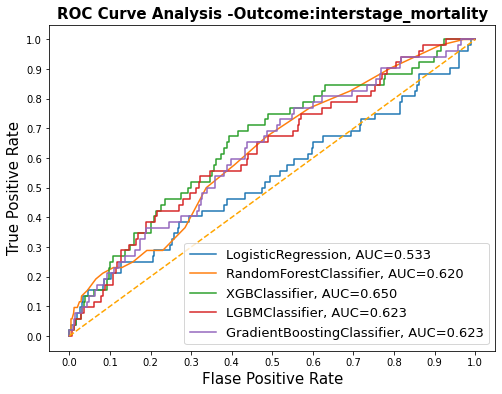

In [1123]:
plot_multiple_ROC(simp_result_table, 'Outcome:interstage_mortality')

## Intepret model

### modeling stage

In [1124]:
import lightgbm as lgb
category_features = ['s1d_followup','s1d_nut_typ', 'avvr_at_discharge',
                     'sex', 'diagnosis', 'phase',
                     'function_at_discharge', 'race', 'ethnicity', 
                     'norwood_type', 'nutrition_route']
# d_train = lgb.Dataset(X_train, label=y_train, 
#                       categorical_feature=category_features)
# d_test = lgb.Dataset(X_test, label=y_test,categorical_feature=category_features)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [1125]:
params = {
    "max_bin": 512,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": [ "auc"],
#     'first_metric_only': True,
    'max_depth': 8, # seems does not matter
    "num_leaves": 20,
    "lambda_l1": 1.8, #good for avoid overfitting
    "lambda_l2": 1.1,
    "verbose": -1,
    "min_data": 100,
#     'is_unbalance': True,
    "boost_from_average": True,
    "min_data_per_group":10,
    'cat_smooth':0.8
}
model = lgb.train(params, d_train, 10000, valid_sets=[d_train,d_test], early_stopping_rounds=30, 
                  verbose_eval=1000) 

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	training's auc: 0.886295	valid_1's auc: 0.714857


In [1126]:
y_pred = model.predict(X_test)
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, recall)
roc_auc

0.7148567119155355

In [1127]:
# mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
#           objective = 'binary',
#           n_jobs = 5, 
#           silent = True,
#           max_depth = params['max_depth'],
#           max_bin = params['max_bin'],
#           subsample_for_bin = params['subsample_for_bin'],
#           subsample = params['subsample'],
#           subsample_freq = params['subsample_freq'],
#           min_split_gain = params['min_split_gain'],
#           min_child_weight = params['min_child_weight'],
#           min_child_samples = params['min_child_samples'],
#           scale_pos_weight = params['scale_pos_weight'],
#           lambda_l1 = params['lambda_l1'],
#           lambda_l2 = params['lambda_l2'])

<strong> Explain predictions using Shap </strong>

In [1128]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [1129]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [1130]:
if isinstance(shap_values, list):
    print("ddd")
    shap_values = shap_values[1]
    
if isinstance(expected_value, list):
    print("eee")
    expected_value = expected_value[1]

ddd


<strong>Summarize the effect of all the features</strong>

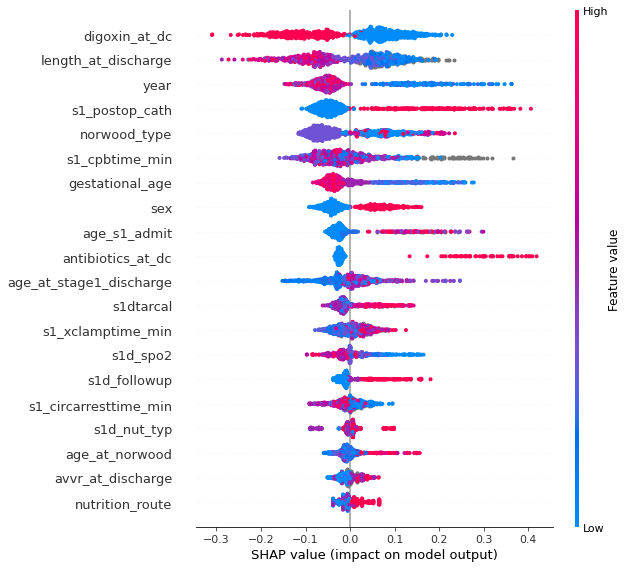

In [1131]:
fig = plt.figure(figsize=(10,14))
fig = shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
# plt.savefig("./result/feature_importance.png", format = "png",dpi = 150,bbox_inches = 'tight')

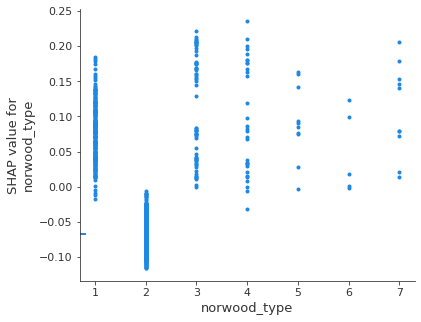

In [1133]:
shap.dependence_plot("norwood_type", shap_values, X_test, interaction_index=None)

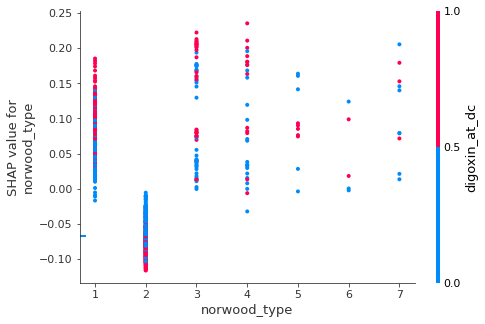

In [1134]:
shap.dependence_plot("norwood_type", shap_values, X_test)

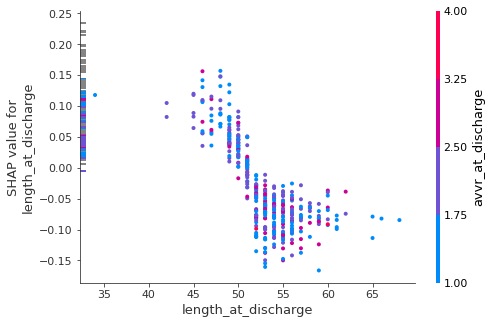

In [1135]:
shap.dependence_plot("length_at_discharge", shap_values, X_test)

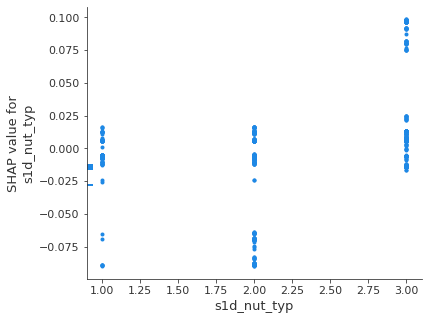

In [1136]:
shap.dependence_plot("s1d_nut_typ", shap_values, X_test, interaction_index=None)

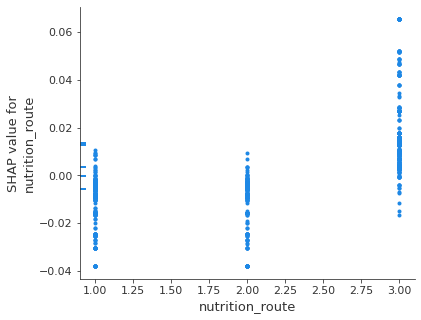

In [1137]:
shap.dependence_plot("nutrition_route", shap_values, X_test, interaction_index=None)

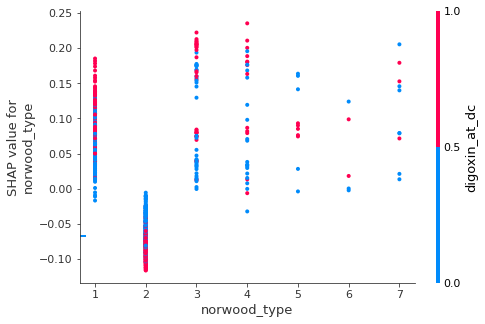

In [1138]:
shap.dependence_plot("norwood_type", shap_values, X_test)

### check if whether Sano had lower risk than BT shunt for norwood_type

In [1139]:
## check if whether Sano had lower risk than BT shunt for norwood_type
from scipy.stats import fisher_exact
selected_norwood = df[(df['norwood_type'] == 1) | (df['norwood_type'] == 2)]
selected_norwood.shape

(2813, 168)

In [1140]:
obs = pd.crosstab(index=selected_norwood['interstage_mortality'],
                      columns=selected_norwood['norwood_type'])
oddsratio, pvalue = fisher_exact(obs)

In [1141]:
print("oddsratio", oddsratio)
print("p-value", pvalue)

oddsratio 0.6109026686271527
p-value 0.00419552392615146


In [1142]:
# mortaility percentage among group norwood_type 1 BT %
100* df[(df['norwood_type'] == 1) & (df['interstage_mortality'] == 1) ].shape[0]/df[df['norwood_type'] == 1].shape[0]

7.04375667022412

In [1143]:
# mortaility rate among group norwood_type 2 Sano %
100*df[(df['norwood_type'] == 2) & (df['interstage_mortality'] == 1) ].shape[0]/df[df['norwood_type'] == 2].shape[0]

4.424307036247335

In [1144]:
## BT receives digoxin
df[(df['norwood_type'] == 2) &  (df['digoxin_at_dc']==0) & (df['interstage_mortality'] == 1) ].shape[0]/ df[(df['norwood_type'] == 2) &  (df['digoxin_at_dc']==0)].shape[0]

0.060352831940575676

In [1145]:
norwood_BT = df[(df['norwood_type'] == 1)]
selected_norwood.shape

(2813, 168)

In [1146]:
## BT receives digoxin
df[(df['norwood_type'] == 2) &  (df['digoxin_at_dc']==1) & (df['interstage_mortality'] == 1) ].shape[0]/ df[(df['norwood_type'] == 2) &  (df['digoxin_at_dc']==1)].shape[0]

0.02252816020025031

### check if age_s1_admit are associated with interstage_mortality

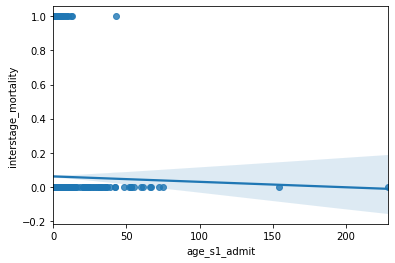

In [1147]:
#whote dataset
g = sns.regplot(x="age_s1_admit", y="interstage_mortality", data=df)

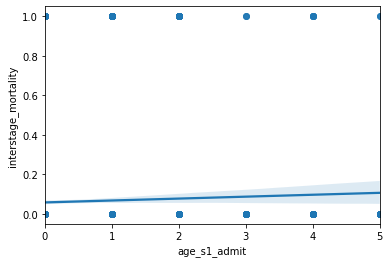

In [1148]:
g = sns.regplot(x="age_s1_admit", y="interstage_mortality", data= df[df['age_s1_admit']<=5])

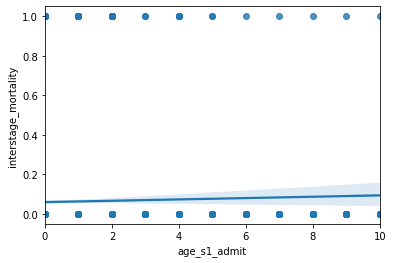

In [1149]:
g = sns.regplot(x="age_s1_admit", y="interstage_mortality", data= df[df['age_s1_admit']<=10])

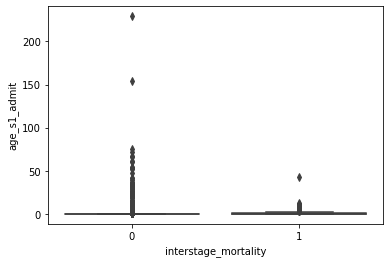

In [1150]:
sns.boxplot(y=df['age_s1_admit'],x=df['interstage_mortality'])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


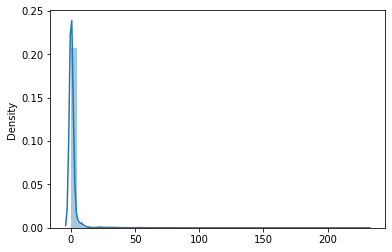

In [1151]:
sns.distplot(x=df['age_s1_admit'])

In [1152]:
df[df['age_s1_admit']==0].shape[0]/df['age_s1_admit'].shape[0]

0.7499234771962044

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


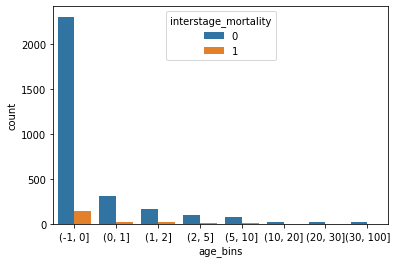

In [1153]:
df['age_bins'] = pd.cut(x=df['age_s1_admit'], bins=[-1, 0, 1,2, 5, 10, 20, 30, 100])
sns.countplot(df['age_bins'], hue=df['interstage_mortality'])

In [1154]:
df[df['age_s1_admit']<2].shape[0]/df.shape[0]

0.849709213345577

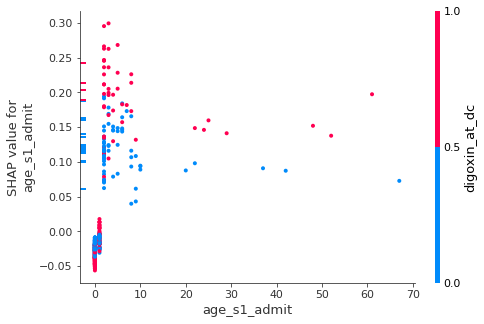

In [1155]:
# prediction
shap.dependence_plot("age_s1_admit", shap_values, X_test)

In [1156]:
print(df[df['interstage_mortality']==1]['age_s1_admit'].mean())
print(df[df['interstage_mortality']==0]['age_s1_admit'].mean())

0.98989898989899
1.2529079428381522


In [1157]:
print(X_test[y_test==1]['age_s1_admit'].mean())
print(X_test[y_test==0]['age_s1_admit'].mean())

0.48936170212765956
1.1731025299600533


In [1158]:
# test assocation between age_s1_admit and the mortaility;
# I do not recommend this Mann-Whitney U because Mann-Whitney U  is test The Mann-Whitney U test is used to 
# compare differences between two independent groups (for example, gender) when the dependent variable (e.g. outcoome) is either ordinal or continuous, but not normally distributed.
from scipy.stats import mannwhitneyu
res = mannwhitneyu(df['age_s1_admit'], df['interstage_mortality'])
res.pvalue

1.3315569619763575e-104

In [1159]:
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats

def logitStats(df, return_only_feature_result=True, **params):
    """
    :param df: dataframe
    :param return_only_feature_result: If True (default), only return the parameters for target feature ; If False,
    return all summary
    :param feature: target feature
    :param covariates:covariates
    :param outcome:outcome
    :return: dict of parameters
    """

    _basic_attr = ['coef', 'std_err', 'z', 'p-value', '[0.025', '0.975]']
    _extended_attr = ['feature', 'coef', 'std_err', 'z', 'p-value', '[0.025', '0.975]', 'n_cases', 'n_controls',
                      'n_total']

    try:
        feature = params['feature']
        outcome = params['outcome']
        covariates = params['covariates']
        print(feature)

    except KeyError:
        raise

    try:
        if isinstance(feature, list):
            feature_formula = " + ".join([f for f in feature])
        else:
            print("not list")
            feature_formula = feature

        if covariates is not None:
            covariates_formula = " + ".join([f for f in covariates])
            y, X = dmatrices('{0} ~ {1} + {2}'.format(outcome, feature_formula, covariates_formula), data=df,
                             return_type='dataframe')

        else:
            y, X = dmatrices('{0} ~ {1}'.format(outcome, feature_formula),  data=df, return_type='dataframe')

        mod = sm.Logit(y, X)
        res = mod.fit()
        smry = res.summary()
        print(smry)
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print("{} has {}".format(feature, err))
        else:
            raise

In [1160]:
 params = { 'feature': 'age_s1_admit',
            'outcome': 'interstage_mortality',
            'covariates': None
        }
    
logitStats(df, **params)

age_s1_admit
not list
Optimization terminated successfully.
         Current function value: 0.231676
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     interstage_mortality   No. Observations:                 3207
Model:                            Logit   Df Residuals:                     3205
Method:                             MLE   Df Model:                            1
Date:                  Sat, 18 Sep 2021   Pseudo R-squ.:               0.0002272
Time:                          21:27:32   Log-Likelihood:                -742.98
converged:                         True   LL-Null:                       -743.15
                                          LLR p-value:                    0.5612
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.7124      0.075    -36.212      0.000      -2.8

In [1161]:
logitStats(df[df['age_s1_admit']<=50], **params)

age_s1_admit
not list
Optimization terminated successfully.
         Current function value: 0.232396
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     interstage_mortality   No. Observations:                 3194
Model:                            Logit   Df Residuals:                     3192
Method:                             MLE   Df Model:                            1
Date:                  Sat, 18 Sep 2021   Pseudo R-squ.:               6.616e-05
Time:                          21:27:32   Log-Likelihood:                -742.27
converged:                         True   LL-Null:                       -742.32
                                          LLR p-value:                    0.7540
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.7227      0.076    -35.884      0.000      -2.8

In [1162]:
df[df['age_s1_admit']<=5].shape[0]

3061

In [1163]:
logitStats(df[ (df['age_s1_admit']<=5) & (df['age_s1_admit']>0)], **params)

age_s1_admit
not list
Optimization terminated successfully.
         Current function value: 0.256968
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     interstage_mortality   No. Observations:                  611
Model:                            Logit   Df Residuals:                      609
Method:                             MLE   Df Model:                            1
Date:                  Sat, 18 Sep 2021   Pseudo R-squ.:                0.007137
Time:                          21:27:32   Log-Likelihood:                -157.01
converged:                         True   LL-Null:                       -158.14
                                          LLR p-value:                    0.1330
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.9438      0.306     -9.609      0.000      -3.5

In [1164]:
logitStats(df[ (df['age_s1_admit']>0)], **params)

age_s1_admit
not list
Optimization terminated successfully.
         Current function value: 0.249585
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     interstage_mortality   No. Observations:                  757
Model:                            Logit   Df Residuals:                      755
Method:                             MLE   Df Model:                            1
Date:                  Sat, 18 Sep 2021   Pseudo R-squ.:                0.002627
Time:                          21:27:32   Log-Likelihood:                -188.94
converged:                         True   LL-Null:                       -189.43
                                          LLR p-value:                    0.3184
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.5351      0.162    -15.640      0.000      -2.8

In [1165]:
df['born_at_s1_admit'] = np.where(df['age_s1_admit'] > 0, 1, 0) 

In [1166]:
obs = pd.crosstab(index=df['interstage_mortality'],
                      columns=df['born_at_s1_admit'])
oddsratio, pvalue = fisher_exact(obs)
pvalue

0.49831106994996066

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


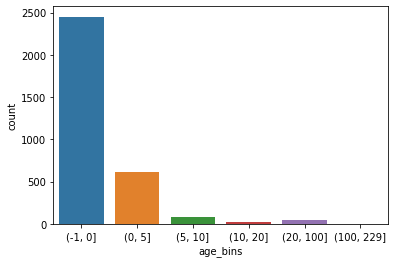

In [1167]:
df['age_bins'] = pd.cut(x=df['age_s1_admit'], bins=[-1, 0, 5, 10, 20, 100,  229])
sns.countplot(df['age_bins'])

In [1168]:
df['age_bins'].unique()

[(0.0, 5.0], (-1.0, 0.0], (5.0, 10.0], (20.0, 100.0], NaN, (10.0, 20.0], (100.0, 229.0]]
Categories (6, interval[int64]): [(-1, 0] < (0, 5] < (5, 10] < (10, 20] < (20, 100] < (100, 229]]

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


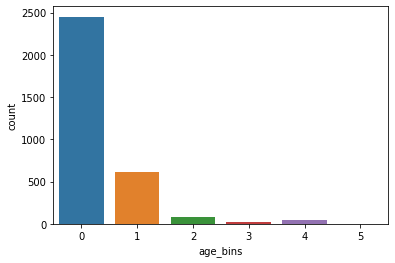

In [1169]:
# it was better use the age bin
df['age_bins'] = pd.cut(x=df['age_s1_admit'], bins=[-1, 0, 5, 10, 20, 100, 229], labels =[0,1,2,3,4, 5])
sns.countplot(df['age_bins'])

obs = pd.crosstab(index=df['interstage_mortality'],
                      columns=df['age_bins'])


In [1170]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(obs, correction=False)
p

0.7016397784499043

In [1171]:
# shap_values_train = explainer.shap_values(X_train)
# shap.summary_plot(shap_values_train[1], X_train)

In [1172]:
# expected_value = explainer.expected_value
# shap.decision_plot(expected_value, shap_values, features_display)

In [1173]:
# lgb.plot_importance(model, max_num_features=21, importance_type='split')

### Error analysis

In [1195]:
# find best threthold cut-off
def find_best_threthold(y_label, y_pred):
    fpr, tpr, thresholds = roc_curve(y_label, y_pred)
    # get the best threshold
    J = tpr - fpr
    ix = argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('Best Threshold idx=%f' % (ix))
    print('Best tpr=%f' % tpr[ix])
    print('Best fpr=%f' % fpr[ix])
    return best_thresh

In [1196]:
y_train_pred = model.predict(X_train)
threthold = find_best_threthold(y_train, y_train_pred)
threthold

Best Threshold=0.073972
Best Threshold idx=192.000000
Best tpr=0.865385
Best fpr=0.212293


0.07397160581708363

In [1217]:
threthold = find_best_threthold(y_test, y_pred)
threthold

Best Threshold=0.067150
Best Threshold idx=55.000000
Best tpr=0.673077
Best fpr=0.308497


0.06715017960125721

In [1218]:
predictions = np.where(y_pred >threthold, 1, 0) 

In [1219]:
# compute the accuracy, balanced accuracy, F1
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
print('accuracy', accuracy_score(y_test, predictions))
print('f1 score', f1_score(y_test, predictions))
print('balanced_accuracy_score', balanced_accuracy_score(y_test, predictions))

accuracy 0.6891064871481029
f1 score 0.21118012422360247
balanced_accuracy_score 0.6726747109100051


In [1220]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [1221]:
Specificity = tn/y_test[y_test==0].shape[0]
Specificity

0.6915032679738562

In [1222]:
Sensitivity = tp / y_test[y_test==1].shape[0]
Sensitivity

0.6538461538461539

In [1216]:
predictions[predictions==1].shape[0]/predictions.shape[0]

0.33047735618115054

In [1223]:
y_test[y_test==1].shape[0]/y_test.shape[0]

0.06364749082007344

In [1224]:
# find not equal prediction
np.where( (~np.equal(predictions, y_test)) & (predictions<y_test))

(array([ 38,  90, 122, 154, 181, 231, 366, 385, 390, 418, 421, 515, 546,
        556, 584, 672, 692, 807]),)

Explain a single patient'soutcome

In [1225]:
X_test_reidx=X_test.reset_index(drop=True)
# X_test_reidx[X_test_reidx.iloc[:,66]>2][['age_s1_admit'][:10]

In [1226]:
idx = 157
#23
print("Predictions", predictions[idx])
print("True labels", y_test[idx])
shap.force_plot(expected_value, shap_values[idx,:], X_test.iloc[idx,:])

Predictions 1
True labels 0


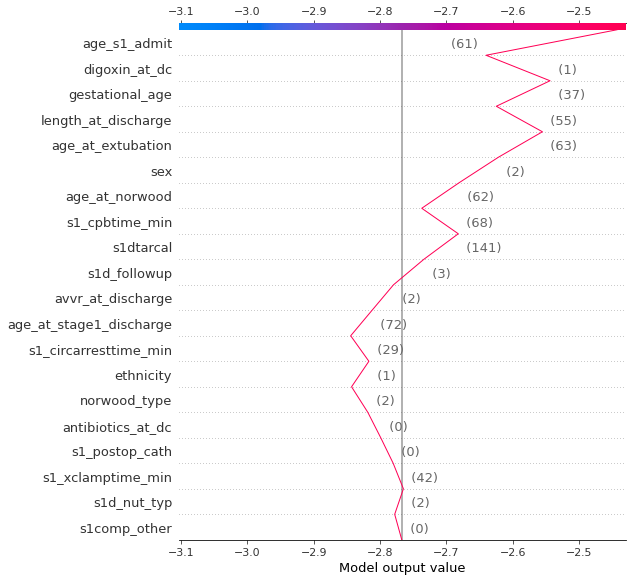

In [1227]:
# feature_display_range=None, slice(-1, -21, -1) 
shap.decision_plot(expected_value, shap_values[idx,:], X_test.iloc[idx,:])

## cross validation

In [1228]:
data.shape

(3267, 164)

In [1229]:
data.head()

,fetal_diagnosis,fetal_intervention,fetalintervention_aov,fetalintervention_asd,fetalintervention_pm,fetalintervention_other,year,anomalies_cns,anomalies_gi,anomalies_renal_gu,...,syndrome_any,anomalies_any,riskfactor_any,norwood_type,nutrition_route,gestational_age,s1comp_chylo,phase,s1comp_nec,anomalies_endo
0,0.0,0.0,0,0,0,0,2014,0,0,0,...,0,0,1,3.0,1.0,38.0,0,1,0,0.0
1,1.0,0.0,0,0,0,0,2012,0,0,0,...,0,0,0,2.0,2.0,37.0,0,1,0,0.0
2,1.0,0.0,0,0,0,0,2019,0,0,0,...,0,0,0,2.0,3.0,39.0,0,2,0,NaN
3,NaN,NaN,0,0,0,0,2013,0,0,0,...,0,0,0,2.0,3.0,39.0,0,1,0,0.0
4,1.0,0.0,0,0,0,0,2016,0,0,0,...,0,0,0,2.0,3.0,40.0,0,2,0,NaN


In [1230]:
params = {
    "max_bin": 512,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": [ "auc"],
#     'first_metric_only': True,
    'max_depth': 8, # seems does not matter
    "num_leaves": 20,
    "lambda_l1": 1.8, #good for avoid overfitting
    "lambda_l2": 1.1,
    "verbose": -1,
    "min_data": 100,
#     'is_unbalance': True,
    "boost_from_average": True,
    "min_data_per_group":10,
    'cat_smooth':0.8
}
d_data = lgb.Dataset(data, label=target, categorical_feature=category_features)

In [1231]:
modelstart= time.time()
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(
    params = params,
    train_set = d_data,
    num_boost_round=5000,
    stratified=False,
    nfold = 5,
    verbose_eval=-1,
    seed = 23,
    shuffle=True)

Using categorical_feature in Dataset.


In [1232]:
lgb_cv

{'auc-mean': [0.561927514960315,
  0.5706912615996508,
  0.5948000941023481,
  0.6024300415778271,
  0.6049915246858275,
  0.6087994918768012,
  0.6154202122561296,
  0.6157996392663013,
  0.616481113592309,
  0.6218210437590801,
  0.6185199019552089,
  0.6237957110592529,
  0.6237772634032019,
  0.6288829905493569,
  0.6284467908661058,
  0.6315317217143548,
  0.6279369296182008,
  0.6312649090595976,
  0.6323489394129227,
  0.6338384040543198,
  0.633502282458589,
  0.6357475727086748,
  0.6369732425238427,
  0.6355019265255157,
  0.637058283968852,
  0.6361311545544842,
  0.6361150486110461,
  0.6336016482518655,
  0.6335290910595985,
  0.6345231338512656,
  0.634458406945422,
  0.6320605274325624,
  0.6336604057723164,
  0.6347146315966491,
  0.6351892880634171,
  0.6332147529951883,
  0.6322737353147687,
  0.6324717571490461,
  0.6331192391920347,
  0.6333784064395369,
  0.6332849617052909,
  0.6350653661777989,
  0.6366938582536488,
  0.6362071073407897,
  0.6355299537538845,
  0

In [1233]:
optimal_rounds = np.argmax(lgb_cv['auc-mean'])
best_cv_score = max(lgb_cv['auc-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds,best_cv_score,lgb_cv['auc-stdv'][optimal_rounds]))

results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])
results = results.append({"Rounds": optimal_rounds,
                          "Score": best_cv_score,
                          "STDV": lgb_cv['auc-stdv'][optimal_rounds],
                          "LB": None,
                          "Parameters": params}, ignore_index=True)
# if Home is True:
#     with open('results.csv', 'a') as f:
#         results.to_csv(f, header=False)


Optimal Round: 50
Optimal Score: 0.6411966905701174 + 0.05493084871932548


In [1234]:
lgb_cv.keys()

dict_keys(['auc-mean', 'auc-stdv'])